# Improved LSTM baseline

This kernel is a somewhat improved version of [Keras - Bidirectional LSTM baseline](https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-051) along with some additional documentation of the steps.

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


We include the GloVe word vectors in our input files. To include these in your kernel, simple click 'input files' at the top of the notebook, and search 'glove' in the 'datasets' section.

In [2]:
EMBEDDING_FILE='inputtest_article_comments_nosurf_dim100_epoch5.txt'
TRAIN_DATA_FILE='input/train.csv'
TEST_DATA_FILE='input/test.csv'

Set some basic config parameters:

In [3]:
embed_size = 100 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

Read in our data and replace missing values:

In [4]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)
train[COMMENT] = train[COMMENT].str.lower().str.replace('https?:\/\/[^\s]*','').str.replace("’","'").str.replace("''",' ').str.replace("'"," ' ").str.replace('“','"').str.replace('”','"').str.replace('"',' : ').str.replace('.',' . ').str.replace(',',' , ').str.replace('[',' [ ').str.replace(']',' ] ').str.replace('(',' ( ').str.replace(')',' ) ').str.replace('!',' ! ').str.replace('?',' ? ').str.replace(';',' ').str.replace(':',' ').str.replace('-',' - ').str.replace('=', ' ').str.replace('=', ' ').str.replace('*', ' ').str.replace('|', ' ').str.replace('«', ' ').str.replace('\d', ' ').str.replace('\n', ' ').str.replace('\s\s+',' ').str.replace('\n','NEWLINE ').str.strip().str.replace("[^\s\d\w)(;:\-+_?!\]\[,*,'\"]+","")
test[COMMENT] = test[COMMENT].str.lower().str.replace('https?:\/\/[^\s]*','').str.replace("’","'").str.replace("''",' ').str.replace("'"," ' ").str.replace('“','"').str.replace('”','"').str.replace('"',' : ').str.replace('.',' . ').str.replace(',',' , ').str.replace('[',' [ ').str.replace(']',' ] ').str.replace('(',' ( ').str.replace(')',' ) ').str.replace('!',' ! ').str.replace('?',' ? ').str.replace(';',' ').str.replace(':',' ').str.replace('-',' - ').str.replace('=', ' ').str.replace('=', ' ').str.replace('*', ' ').str.replace('|', ' ').str.replace('«', ' ').str.replace('\d', ' ').str.replace('\n', ' ').str.replace('\s\s+',' ').str.replace('\n','NEWLINE ').str.strip().str.replace("[^\s\d\w)(;:\-+_?!\]\[,*,'\"]+","")

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

In [5]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

In [6]:
dim = 100
def get_coefs(*tokens):     
    tokens_len = len(tokens)
    word = ''.join(tokens[:tokens_len-dim])
    vector = tokens[tokens_len-dim:]
    return word,np.asarray(vector, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

In [7]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(-0.006385698, 0.30856162)

In [8]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

In [9]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now we're ready to fit out model! Use `validation_split` when not submitting.

In [41]:
from keras import callbacks
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc =[]
        self.batch = []
        self.logs_backup = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.batch.append(batch)
        self.logs_backup.append(logs)
    
history = LossHistory()
model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.10, callbacks=[history]);

Train on 86265 samples, validate on 9586 samples
Epoch 1/2
86265/86265 [==============================] - 1444s - loss: 0.0358 - acc: 0.9858 - val_loss: 0.0367 - val_acc: 0.9857
Epoch 2/2
86265/86265 [==============================] - 1352s - loss: 0.0304 - acc: 0.9877 - val_loss: 0.0401 - val_acc: 0.9852


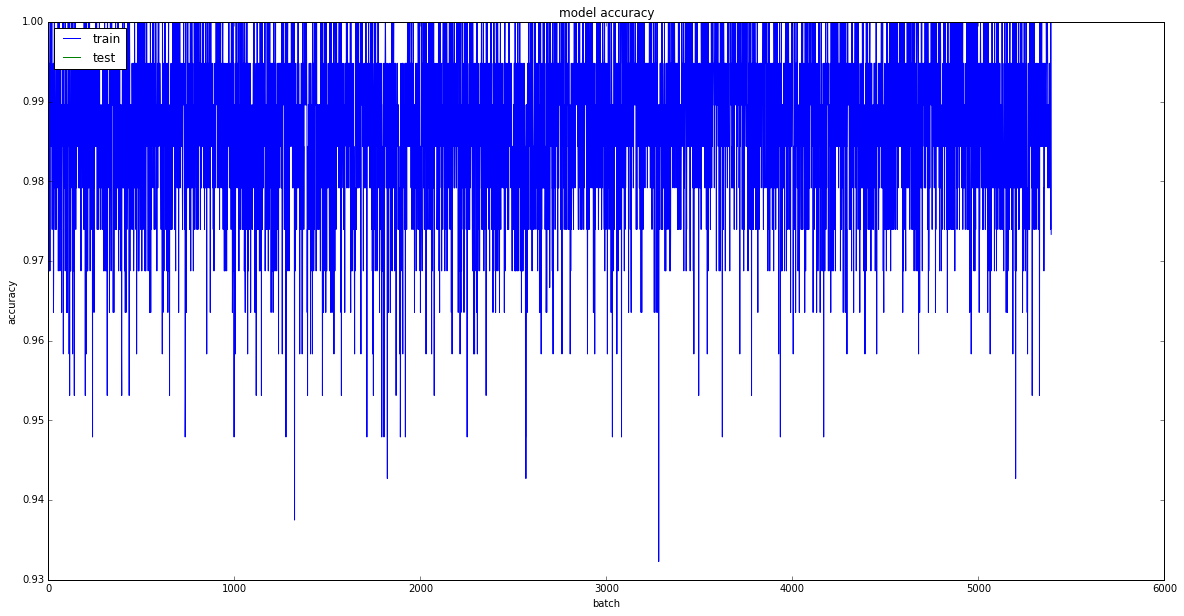

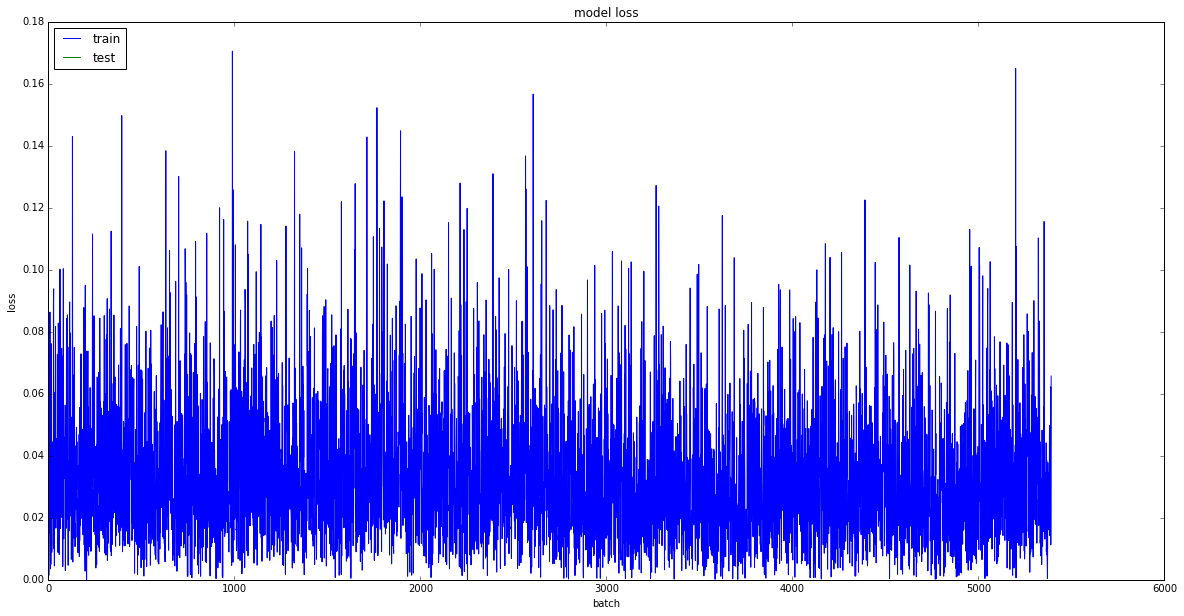

In [49]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.figure(figsize=(20,10))
plt.plot(history.acc)
plt.plot(history.val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(20,10))
plt.plot(history.losses)
plt.plot(history.val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
class EarlyStoppingByLoss(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_batch_end(self, batch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Batch %05d: early stopping THR" % batch)
            self.model.stop_training = True

callbacks = [
    EarlyStopping(monitor='loss', value=0.035, verbose=1),
    # EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
]
            
model.fit(X_t, y, batch_size=32, epochs=2, callbacks=callbacks);

In [10]:
model.fit(X_t, y, batch_size=32, epochs=2);

Epoch 1/2
95851/95851 [==============================] - 1530s - loss: 0.0567 - acc: 0.9802  
Epoch 2/2
95851/95851 [==============================] - 1644s - loss: 0.0417 - acc: 0.9838  


And finally, get predictions for the test set and prepare a submission CSV:

dict_keys(['loss', 'acc'])


KeyError: 'val_acc'

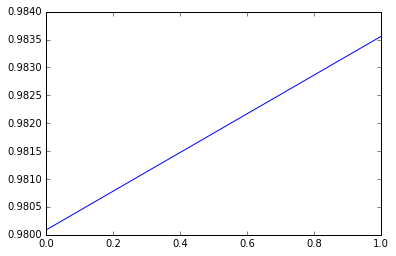

In [13]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)

226998/226998 [==============================] - 904s   


In [12]:
sample_submission = pd.read_csv('input/sample_submission.csv')

In [13]:
sample_submission[list_classes] = y_test
sample_submission.to_csv('submission.csv', index=False)